## Automated anisotropic resistivity inversion for efficient formation evaluation and uncertainty quantification

### Misael M. Morales, Ali Eghbali, Oriyomi Raheem, Michael Pyrcz, Carlos Torres-Verdin
***
## PINN-based Inversion (PyTorch)
***

In [1]:
from main import *

check_torch()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
case1, case2, synthetic1, synthetic2 = load_all_data()


------------------------------------------------------------
----------------------- VERSION INFO -----------------------
Torch version: 2.1.2.post300 | Torch Built with CUDA? True
# Device(s) available: 1, Name(s): NVIDIA GeForce RTX 3080
------------------------------------------------------------

Name              : Source                : Shape
----------------- : --------------------- : -----------
Field Case 1      : (Chevron)             : (2399, 12)
Field Case 2      : (AkerBP)              : (11143, 12)
Synthetic Case 1  : (Laminated)           : (801, 14)
Synthetic Case 2  : (Laminated+Dispersed) : (415, 10)


***
### Physics-informed neural network inversion

In [2]:
class PINNLoss(nn.Module):
    def __init__(self, dd_flag:bool=True, ddmax=100, lambda_reg=1e-10, lambda_p=2):
        super(PINNLoss, self).__init__()
        self.lambda_reg = lambda_reg
        self.lambda_p   = lambda_p
        self.dd_flag    = dd_flag
        self.ddmax      = ddmax

    def forward(self, inputs, outputs):
        Rv_true  = inputs[:, 0]
        Rh_true  = inputs[:, 1]
        dd_true  = inputs[:, 2]/self.ddmax
        Rvsh     = inputs[:, 3]
        Rhsh     = inputs[:, 4]
        Csh_pred = outputs[:, 0]
        Rss_pred = outputs[:, 1]

        eq1 = (Csh_pred*Rvsh + (1-Csh_pred)*Rss_pred) - (Rv_true)
        eq2 = 1/(Csh_pred/Rhsh + (1-Csh_pred)/Rss_pred) - (Rh_true)
        eqs = torch.stack([eq1, eq2], dim=-1)

        if self.dd_flag:
            wd1, wd2 = 1/Rv_true/dd_true, 1*Rh_true/dd_true
        else:
            wd1, wd2 = 1/Rv_true, 1*Rh_true
        Wdm = torch.stack([wd1, wd2], dim=-1)

        costf = torch.norm(torch.matmul(Wdm.T, eqs), p=2)
        regPa = self.lambda_reg*torch.norm(outputs, p=self.lambda_p)

        return  costf + regPa

In [3]:
class DataLoss(nn.Module):
    def __init__(self, loss_fn=nn.MSELoss(), lambda_p=2):
        super(DataLoss, self).__init__()
        self.dd_loss = loss_fn
        self.lambda_p = lambda_p

    def forward(self, inputs, outputs):
        Rv_true  = inputs[:, 0]
        Rh_true  = inputs[:, 1]
        dd_true  = inputs[:, 2]
        Rvsh     = inputs[:, 3]
        Rhsh     = inputs[:, 4]
        Csh_pred = outputs[:, 0]
        Rss_pred = outputs[:, 1]
        Rv_sim = (Csh_pred*Rvsh + (1-Csh_pred)*Rss_pred)
        Rh_sim = 1/(Csh_pred/Rhsh + (1-Csh_pred)/Rss_pred)
        v_loss = self.dd_loss(Rv_sim, Rv_true)
        h_loss = self.dd_loss(Rh_sim, Rh_true)
        return torch.norm(torch.stack([v_loss, h_loss], dim=-1), p=self.lambda_p)

In [4]:
class ResInvPINN(nn.Module):
    def __init__(self, hidden_dim:int=128, csh_constraint_mult=1.0):
        super(ResInvPINN, self).__init__()
        self.fc1  = nn.Linear(2, hidden_dim)
        self.fc2  = nn.Linear(hidden_dim, hidden_dim)
        self.fc3  = nn.Linear(hidden_dim, 2)
        self.mult = csh_constraint_mult

    def constraints(self, d):
        c, s = d[:, 0], d[:, 1]
        c = self.mult*torch.sigmoid(c)
        return torch.stack([c, s], dim=-1)
       
    def forward(self, x):
        x = x[:, :2]
        
        x = self.fc1(x)
        x = nn.Tanh()(x)

        x = self.fc2(x)
        x = nn.Tanhshrink()(x)

        x = self.fc3(x)
        x = self.constraints(x)

        return x

***

In [18]:
column_names = ['CALI', 'AT10', 'AT30', 'AT60', 'AT90', 'GR', 'Rv', 'Rh', 'Rvsh', 'Rhsh']

zstart = int(np.argwhere(case1.index==9720).squeeze())
zend   = int(np.argwhere(case1.index==10110).squeeze())
data1  = case1.iloc[zstart:zend]

zstart = int(np.argwhere(case2.index==6292.75).squeeze())
zend   = int(np.argwhere(case2.index==9078.25).squeeze())
data2  = case2.iloc[zstart:zend]

data3 = synthetic1.dropna()
data4 = synthetic2.dropna()

data_all = pd.concat([data1, data2, data3, data4], ignore_index=False)
print('Data_all: {}'.format(data_all.shape))

Data_all: (13896, 18)


In [ ]:
dd = 'GR'
res_aniso = data_all[['Rv','Rh', dd, 'Rvsh', 'Rhsh']].dropna()
inputs = torch.tensor(res_aniso.values, dtype=torch.float32).to(device)
print('Inputs: {}'.format(inputs.shape))

In [ ]:
dataset        = TensorDataset(inputs)
train_percent  = 0.8
n_train        = int(train_percent*len(dataset))
xtrain, xvalid = random_split(dataset, [n_train, len(dataset)-n_train])
print('X_train: {} | X_valid: {}'.format(len(xtrain), len(xvalid)))

batch_size  = 32
trainloader = DataLoader(xtrain, batch_size=batch_size, shuffle=True)
validloader = DataLoader(xvalid, batch_size=batch_size, shuffle=True)

In [ ]:
model     = ResInvPINN(hidden_dim=150).to(device)

criterion = PINNLoss(ddmax=data_all[dd].max(), lambda_reg=0, dd_flag=True).to(device)
mseloss   = DataLoss().to(device)

optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-3)

print('# of Parameters: {:,}'.format(sum(p.numel() for p in model.parameters() if p.requires_grad)))

In [ ]:
epochs, monitor = 301, 100
pinn_lambda = 0.85
train_loss, valid_loss = [], []
for epoch in range(epochs):
    # training
    epoch_train_loss = []
    model.train()
    for i, x in enumerate(trainloader):
        optimizer.zero_grad()
        y = model(x[0])
        loss = (pinn_lambda)*criterion(x[0], y) + (1-pinn_lambda)*mseloss(x[0], y)
        loss.backward()
        optimizer.step()
        epoch_train_loss.append(loss.item())
    train_loss.append(np.mean(epoch_train_loss))
    # validation
    model.eval()
    epoch_valid_loss = []
    with torch.no_grad():
        for x in validloader:
            y = model(x[0])
            loss = (pinn_lambda)*criterion(x[0], y) + (1-pinn_lambda)*mseloss(x[0], y)
            epoch_valid_loss.append(loss.item())
        valid_loss.append(np.mean(epoch_valid_loss))
    # progress
    if epoch % monitor == 0:
        print('Epoch: {} | Loss: {:.4f} | Valid Loss: {:.4f}'.format(epoch, train_loss[-1], valid_loss[-1]))

torch.save(model.state_dict(), 'models/model_all.pth')
losses = (train_loss, valid_loss)
plot_loss(losses)

In [ ]:
y_pred = model(inputs[:,:2]).cpu().detach().numpy().squeeze()
Csh_pred, Rss_pred = [y_pred[:, i] for i in range(y_pred.shape[1])]
print('Csh:', ' '*15, 'min: {:.3f}  | max: {:.3f}'.format(Csh_pred.min(), Csh_pred.max()))

Rv_true = res_aniso['Rv'].values
Rh_true = res_aniso['Rh'].values
Rvsh    = res_aniso['Rvsh'].values
Rhsh    = res_aniso['Rhsh'].values

Rv_sim = (Csh_pred*Rvsh + (1-Csh_pred)*Rss_pred)
Rh_sim = 1/(Csh_pred/Rhsh + (1-Csh_pred)/Rss_pred)
Rv_err = np.abs((Rv_sim - Rv_true)/Rv_true) * 100
Rh_err = np.abs((Rh_sim - Rh_true)/Rh_true) * 100

Csh_pred_norm = (Csh_pred - Csh_pred.min())/(Csh_pred.max() - Csh_pred.min())
pinn_sol = pd.DataFrame({'Csh_pred':Csh_pred_norm, 'Rss_pred':Rss_pred, 
                         'Rv_sim':Rv_sim, 'Rh_sim':Rh_sim,
                         'Rv_err':Rv_err, 'Rh_err':Rh_err}, 
                         index=res_aniso.index)

quad_sol = newton_inversion(res_aniso)

results = pd.concat([data_all, pinn_sol, quad_sol], axis=1)
results.to_csv('results/pinn_solution_all.csv', index=True)
error_metrics(results)

***
## Cases

In [5]:
chevron_model      = ResInvPINN(hidden_dim=150).to(device)
chevron_model.load_state_dict(torch.load('models/model_Chevron.pth'))
chevron_results    = pd.read_csv('results/pinn_solution_Chevron.csv', index_col=0)
chevron_gb_results = pd.read_csv('results/gradient_based_solution_Chevron.csv', index_col=0)

akerbp_model       = ResInvPINN(hidden_dim=150).to(device)
akerbp_model.load_state_dict(torch.load('models/model_AkerBP.pth'))
akerbp_results     = pd.read_csv('results/pinn_solution_AkerBP.csv', index_col=0)
akerbp_gb_results  = pd.read_csv('results/gradient_based_solution_AkerBP.csv', index_col=0)

synth1_model       = ResInvPINN(hidden_dim=150).to(device)
synth1_model.load_state_dict(torch.load('models/model_synthetic1.pth'))
synth1_results     = pd.read_csv('results/pinn_solution_synthetic1.csv', index_col=0)
synth1_gb_results  = pd.read_csv('results/gradient_based_solution_synthetic1.csv', index_col=0).iloc[22:]

synth2_model       = ResInvPINN(hidden_dim=150).to(device)
synth2_model.load_state_dict(torch.load('models/model_synthetic2.pth'))
synth2_results     = pd.read_csv('results/pinn_solution_synthetic2.csv', index_col=0)
synth2_gb_results  = pd.read_csv('results/gradient_based_solution_synthetic2.csv', index_col=0)

In [ ]:
s = 'Chevron 2009'
plot_pinn_results(chevron_results, suptitle=s)
plot_pinn_gb_comparison(chevron_results, chevron_gb_results, suptitle=s)

In [ ]:
s = 'AkerBP Hanz Prospect'
plot_pinn_results(akerbp_results, suptitle=s)
plot_pinn_gb_comparison(akerbp_results, akerbp_gb_results, suptitle=s)

In [ ]:
s = 'Synthetic Case 1 (Laminated)'
plot_pinn_results(synth1_results, figsize=(12,12), suptitle=s)
plot_pinn_gb_comparison(synth1_results, synth1_gb_results, suptitle=s)

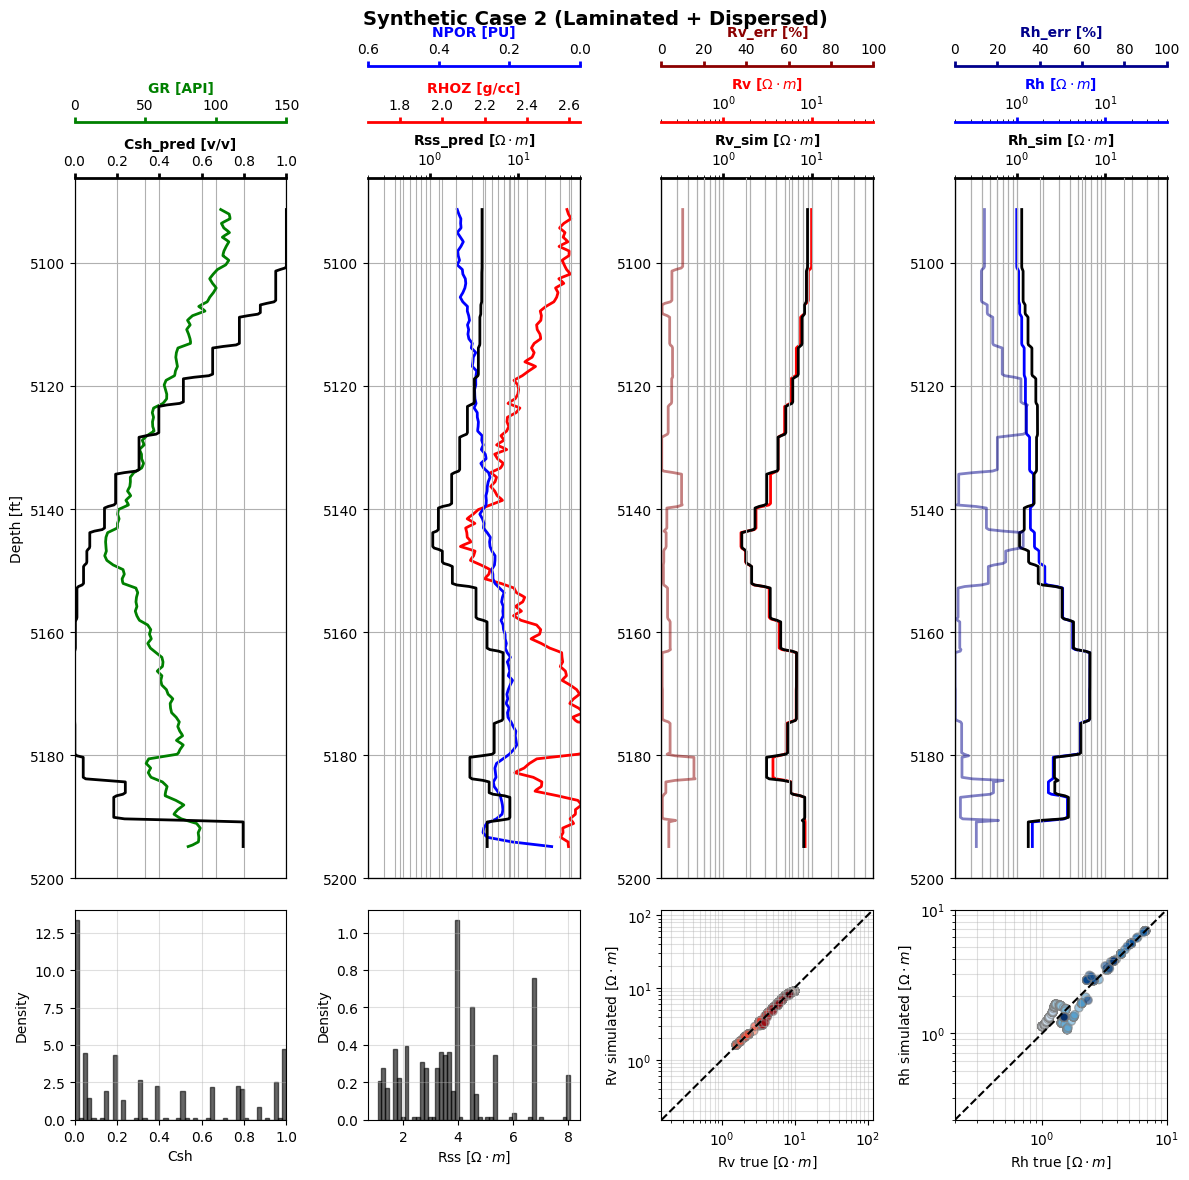

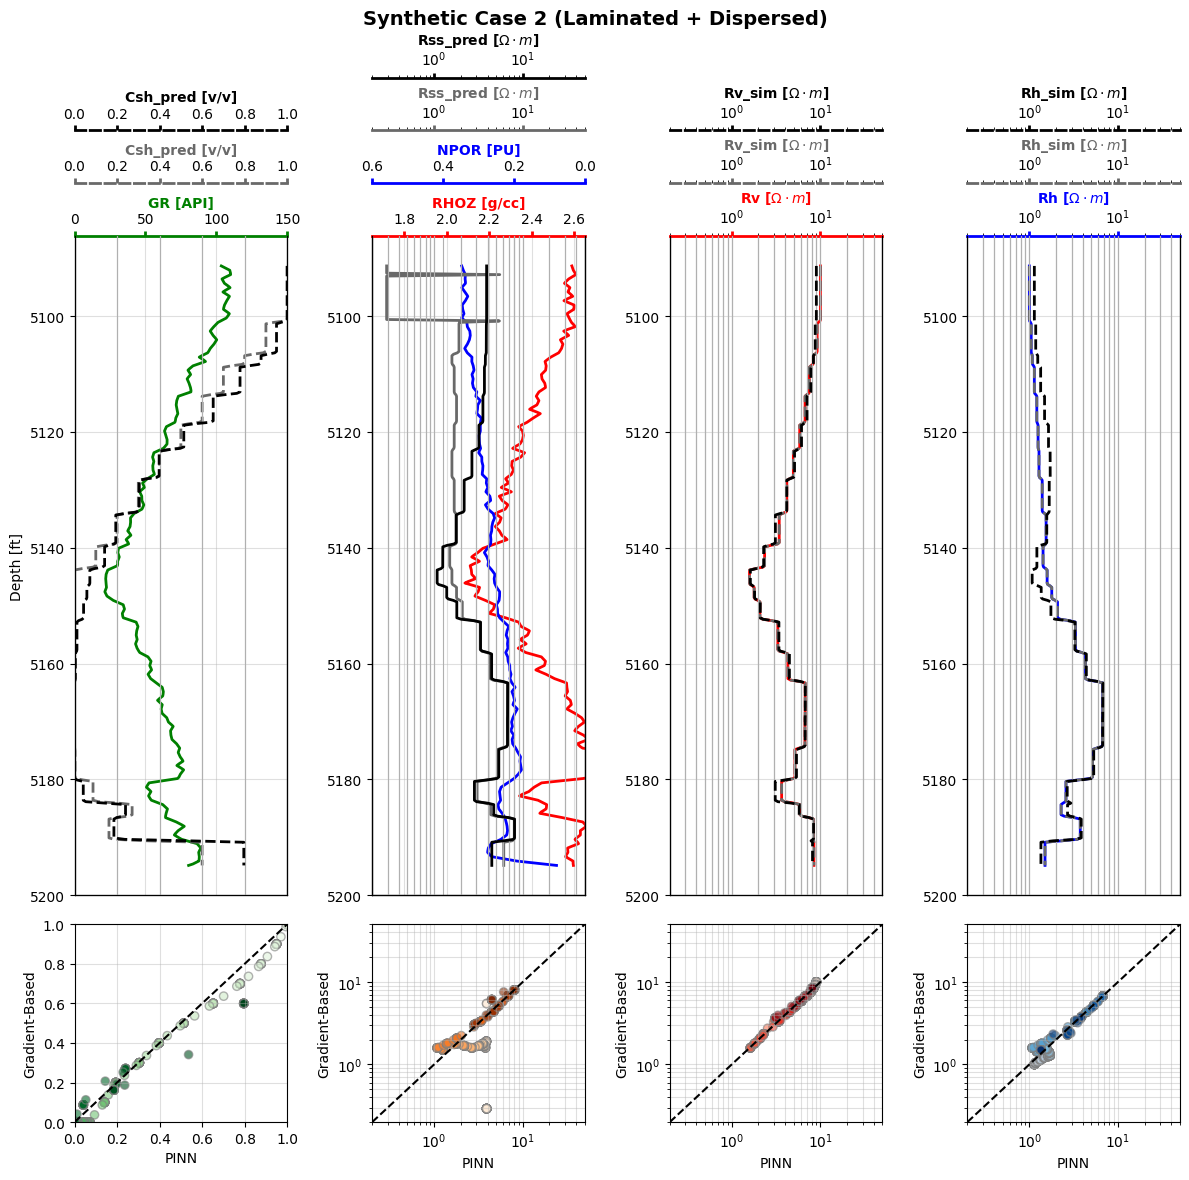

In [6]:
s = 'Synthetic Case 2 (Laminated + Dispersed)'
plot_pinn_results(synth2_results, suptitle=s, at_flag=False)
plot_pinn_gb_comparison(synth2_results, synth2_gb_results, suptitle=s, at_flag=False)

***
## Uncertainty Quantification

In [7]:
n_realizations = 1000
noise_level = 0.05

In [8]:
chevron_uq = np.zeros((n_realizations, chevron_results.shape[0], 2))
for i in range(n_realizations):
    noisy_inputs = chevron_results[['Rv','Rh']] + noise_level*np.random.lognormal(0, 1, size=(chevron_results.shape[0], 2))
    noisy_inputs = torch.tensor(noisy_inputs.values, dtype=torch.float32).to(device)
    chevron_uq[i] = chevron_model(noisy_inputs).cpu().detach().numpy().squeeze()
print(chevron_uq.shape)

chevron_uq_csh = np.zeros((n_realizations, chevron_results.shape[0]))
for i in range(n_realizations):
    c = chevron_uq[i,:,0]
    chevron_uq_csh[i] = (c - c.min())/(c.max() - c.min())

(1000, 1560, 2)


In [9]:
akerbp_uq = np.zeros((n_realizations, akerbp_results.shape[0], 2))
for i in range(n_realizations):
    noisy_inputs = akerbp_results[['Rv','Rh']] + noise_level*np.random.lognormal(0, 1, size=(akerbp_results.shape[0], 2))
    noisy_inputs = torch.tensor(noisy_inputs.values, dtype=torch.float32).to(device)
    akerbp_uq[i] = akerbp_model(noisy_inputs).cpu().detach().numpy().squeeze()
print(akerbp_uq.shape)

akerbp_uq_csh = np.zeros((n_realizations, akerbp_results.shape[0]))
for i in range(n_realizations):
    c = akerbp_uq[i,:,0]
    akerbp_uq_csh[i] = (c - c.min())/(c.max() - c.min())

(1000, 11142, 2)


In [10]:
synthetic1_uq = np.zeros((n_realizations, synth1_results.shape[0], 2))
for i in range(n_realizations):
    noisy_inputs = synth1_results[['Rv','Rh']] + noise_level*np.random.lognormal(0, 1, size=(synth1_results.shape[0], 2))
    noisy_inputs = torch.tensor(noisy_inputs.values, dtype=torch.float32).to(device)
    synthetic1_uq[i] = synth1_model(noisy_inputs).cpu().detach().numpy().squeeze()
print(synthetic1_uq.shape)

synthetic1_uq_csh = np.zeros((n_realizations, synth1_results.shape[0]))
for i in range(n_realizations):
    c = synthetic1_uq[i,:,0]
    synthetic1_uq_csh[i] = (c - c.min())/(c.max() - c.min())

(1000, 779, 2)


In [11]:
synthetic2_uq = np.zeros((n_realizations, synth2_results.shape[0], 2))
for i in range(n_realizations):
    noisy_inputs = synth2_results[['Rv','Rh']] + noise_level*np.random.lognormal(0, 1, size=(synth2_results.shape[0], 2))
    noisy_inputs = torch.tensor(noisy_inputs.values, dtype=torch.float32).to(device)
    synthetic2_uq[i] = synth2_model(noisy_inputs).cpu().detach().numpy().squeeze()
print(synthetic2_uq.shape)

synthetic2_uq_csh = np.zeros((n_realizations, synth2_results.shape[0]))
for i in range(n_realizations):
    c = synthetic2_uq[i,:,0]
    synthetic2_uq_csh[i] = (c - c.min())/(c.max() - c.min())

(1000, 415, 2)


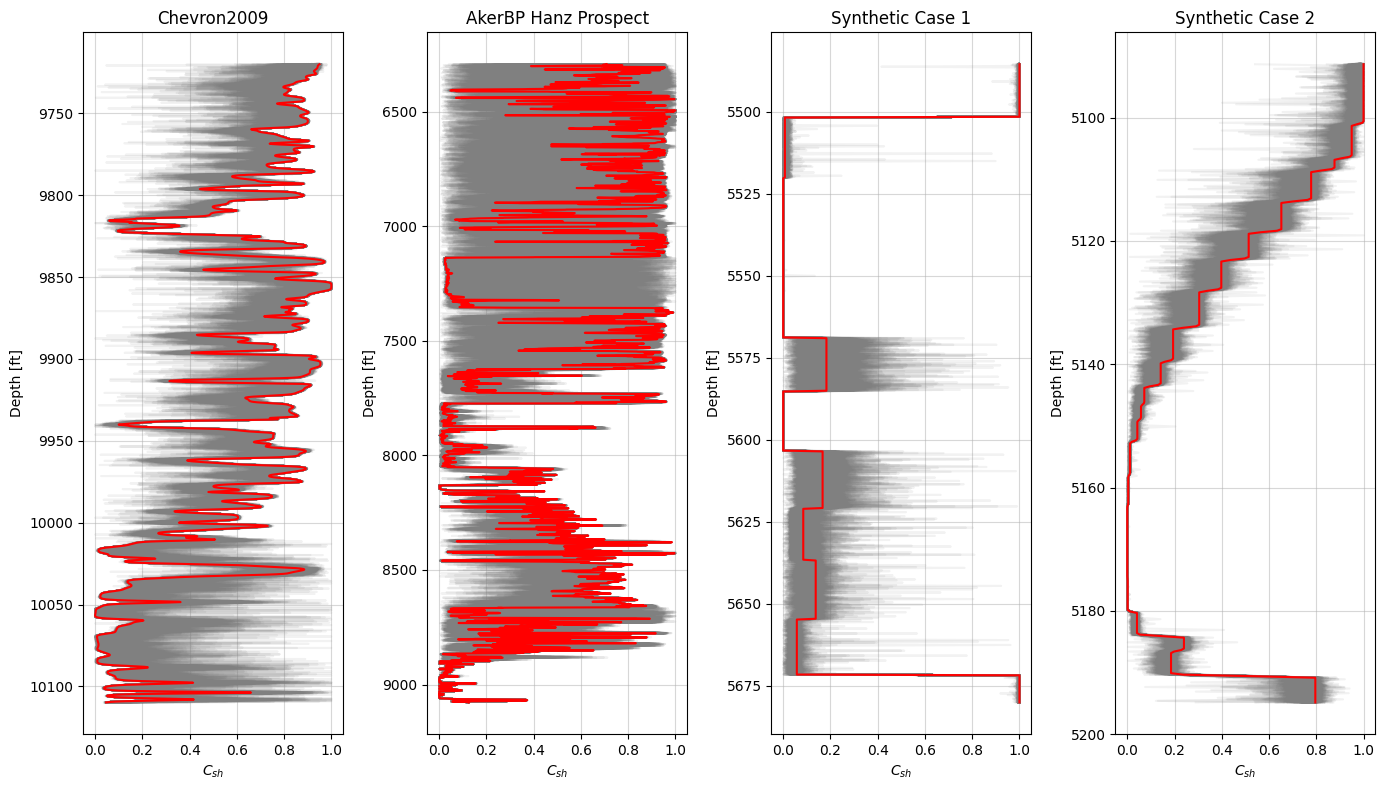

In [12]:
titles = ['Chevron2009', 'AkerBP Hanz Prospect', 'Synthetic Case 1', 'Synthetic Case 2']

fig, axs = plt.subplots(1, 4, figsize=(14,8))
ax1, ax2, ax3, ax4 = axs

for i in range(n_realizations):
    ax1.plot(chevron_uq_csh[i], chevron_results.index, color='gray', alpha=0.1)
    ax2.plot(akerbp_uq_csh[i], akerbp_results.index, color='gray', alpha=0.1)
    ax3.plot(synthetic1_uq_csh[i], synth1_results.index, color='gray', alpha=0.1)
    ax4.plot(synthetic2_uq_csh[i], synth2_results.index, color='gray', alpha=0.1)

ax1.plot(chevron_results['Csh_pred'], chevron_results.index, color='red')
ax2.plot(akerbp_results['Csh_pred'], akerbp_results.index, color='red')
ax3.plot(synth1_results['Csh_pred'], synth1_results.index, color='red')
ax4.plot(synth2_results['Csh_pred'], synth2_results.index, color='red')

[ax.set(title=titles[i], xlabel='$C_{sh}$', ylabel='Depth [ft]', xlim=(-0.05,1.05)) for i, ax in enumerate(axs)]
[ax.invert_yaxis() for ax in axs]
[ax.grid(True, which='both', alpha=0.5) for ax in axs]
plt.tight_layout()
plt.show()

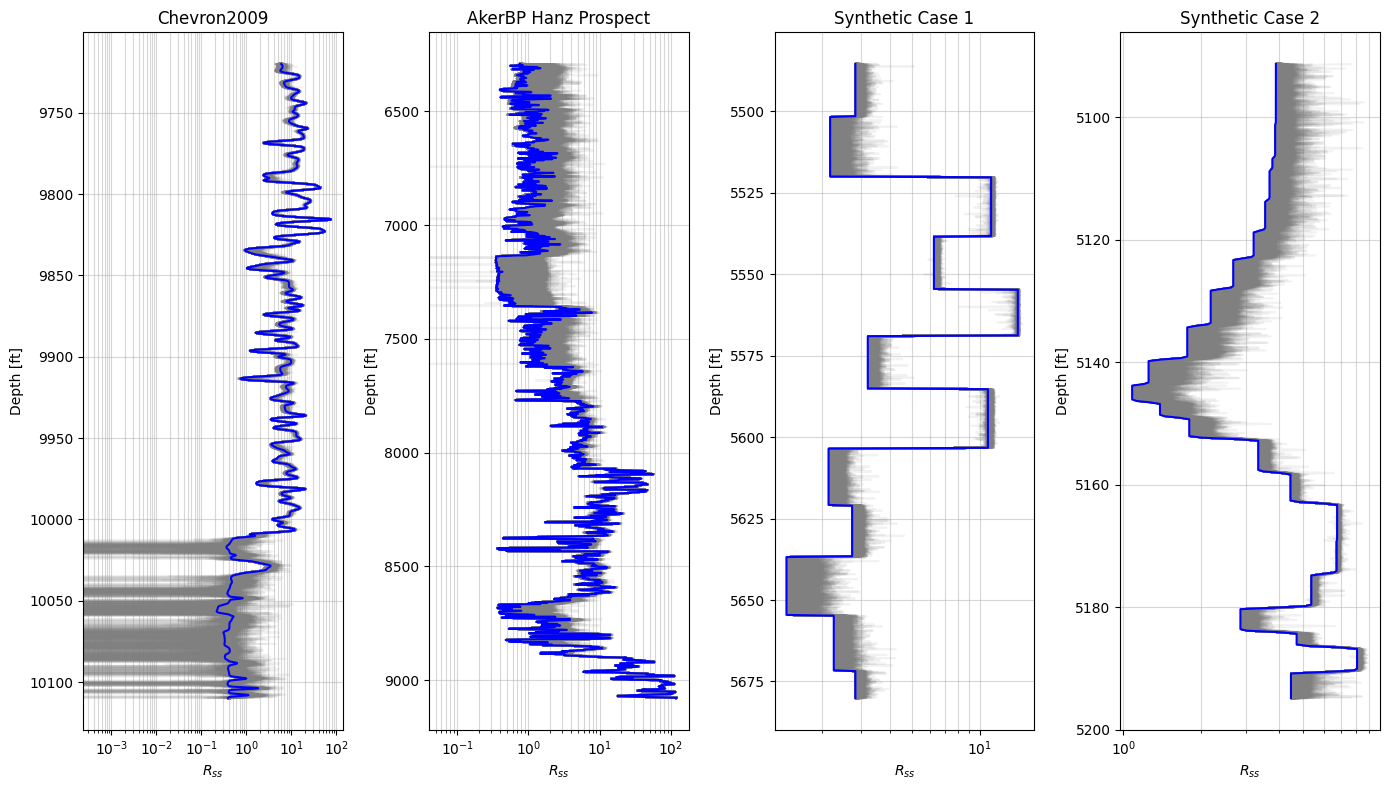

In [13]:
titles = ['Chevron2009', 'AkerBP Hanz Prospect', 'Synthetic Case 1', 'Synthetic Case 2']

fig, axs = plt.subplots(1, 4, figsize=(14,8))
ax1, ax2, ax3, ax4 = axs

for i in range(n_realizations):
    ax1.plot(chevron_uq[i,:,1], chevron_results.index, color='gray', alpha=0.1)
    ax2.plot(akerbp_uq[i,:,1], akerbp_results.index, color='gray', alpha=0.1)
    ax3.plot(synthetic1_uq[i,:,1], synth1_results.index, color='gray', alpha=0.1)
    ax4.plot(synthetic2_uq[i,:,1], synth2_results.index, color='gray', alpha=0.1)

ax1.plot(chevron_results['Rss_pred'], chevron_results.index, color='b')
ax2.plot(akerbp_results['Rss_pred'], akerbp_results.index, color='b')
ax3.plot(synth1_results['Rss_pred'], synth1_results.index, color='b')
ax4.plot(synth2_results['Rss_pred'], synth2_results.index, color='b')

[ax.set(title=titles[i], xlabel='$R_{ss}$', ylabel='Depth [ft]', xscale='log') for i, ax in enumerate(axs)]
[ax.invert_yaxis() for ax in axs]
[ax.grid(True, which='both', alpha=0.5) for ax in axs]
plt.tight_layout()
plt.show()

In [14]:
chevron_csh_range, chevron_rss_range = [], []
for i in range(n_realizations):
    p10_csh, p90_csh = np.percentile(chevron_uq_csh[i], 10), np.percentile(chevron_uq_csh[i], 90)
    p10_rss, p90_rss = np.percentile(chevron_uq[i,:,1], 10), np.percentile(chevron_uq[i,:,1], 90)
    chevron_csh_range.append(p90_csh - p10_csh)
    chevron_rss_range.append(p90_rss - p10_rss)
chevron_csh_range, chevron_rss_range = np.array(chevron_csh_range), np.array(chevron_rss_range)

akerbp_csh_range, akerbp_rss_range = [], []
for i in range(n_realizations):
    p10_csh, p90_csh = np.percentile(akerbp_uq_csh[i], 10), np.percentile(akerbp_uq_csh[i], 90)
    p10_rss, p90_rss = np.percentile(akerbp_uq[i,:,1], 10), np.percentile(akerbp_uq[i,:,1], 90)
    akerbp_csh_range.append(p90_csh - p10_csh)
    akerbp_rss_range.append(p90_rss - p10_rss)
akerbp_csh_range, akerbp_rss_range = np.array(akerbp_csh_range), np.array(akerbp_rss_range)

synth1_csh_range, synth1_rss_range = [], []
for i in range(n_realizations):
    p10_csh, p90_csh = np.percentile(synthetic1_uq_csh[i], 10), np.percentile(synthetic1_uq_csh[i], 90)
    p10_rss, p90_rss = np.percentile(synthetic1_uq[i,:,1], 10), np.percentile(synthetic1_uq[i,:,1], 90)
    synth1_csh_range.append(p90_csh - p10_csh)
    synth1_rss_range.append(p90_rss - p10_rss)
synth1_csh_range, synth1_rss_range = np.array(synth1_csh_range), np.array(synth1_rss_range)

synth2_csh_range, synth2_rss_range = [], []
for i in range(n_realizations):
    p10_csh, p90_csh = np.percentile(synthetic2_uq_csh[i], 10), np.percentile(synthetic2_uq_csh[i], 90)
    p10_rss, p90_rss = np.percentile(synthetic2_uq[i,:,1], 10), np.percentile(synthetic2_uq[i,:,1], 90)
    synth2_csh_range.append(p90_csh - p10_csh)
    synth2_rss_range.append(p90_rss - p10_rss)
synth2_csh_range, synth2_rss_range = np.array(synth2_csh_range), np.array(synth2_rss_range)

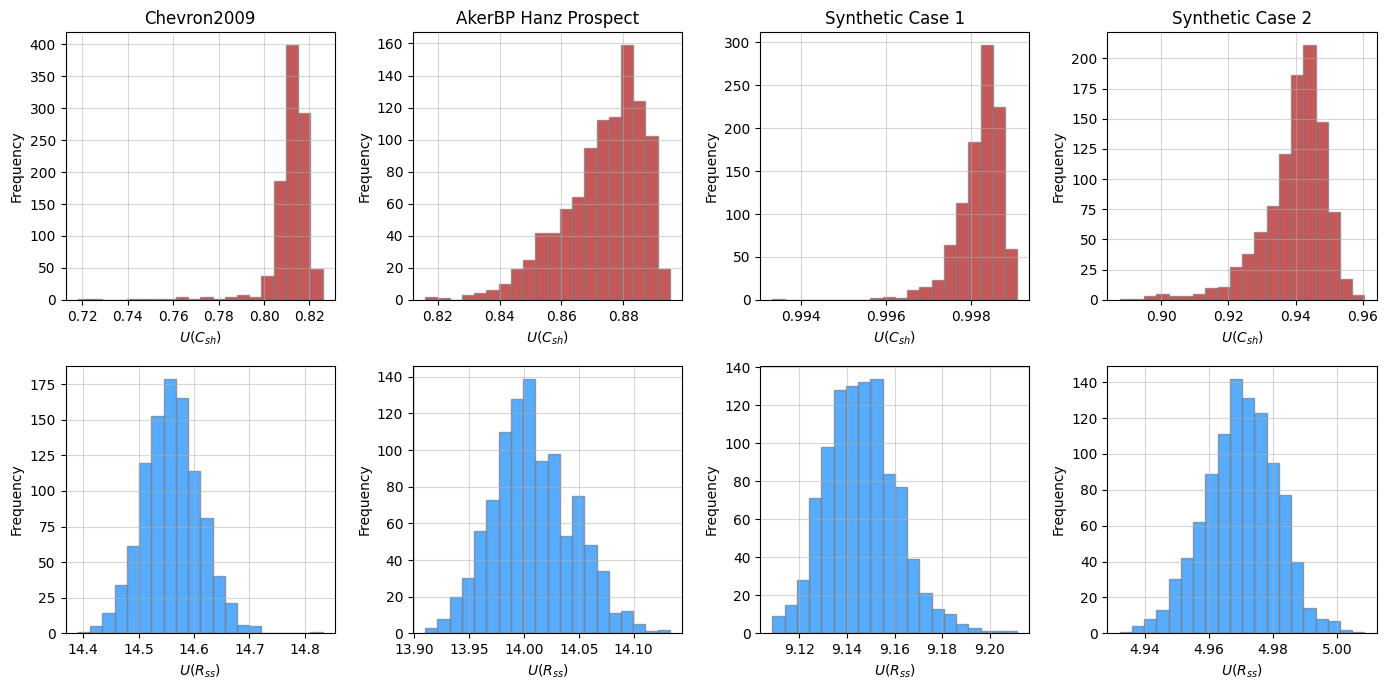

In [15]:
fig, axs = plt.subplots(2, 4, figsize=(14,7))
ax1, ax2, ax3, ax4 = axs[0]
ax5, ax6, ax7, ax8 = axs[1]

ax1.hist(chevron_csh_range, bins=20, color='firebrick', alpha=0.75, edgecolor='gray')
ax2.hist(akerbp_csh_range, bins=20, color='firebrick', alpha=0.75, edgecolor='gray')
ax3.hist(synth1_csh_range, bins=20, color='firebrick', alpha=0.75, edgecolor='gray')
ax4.hist(synth2_csh_range, bins=20, color='firebrick', alpha=0.75, edgecolor='gray')
[ax.grid(True, which='both', alpha=0.5) for ax in axs[0]]
[ax.set(xlabel='$U(C_{sh})$', ylabel='Frequency', title=titles[i]) for i, ax in enumerate(axs[0])]

ax5.hist(chevron_rss_range, bins=20, color='dodgerblue', alpha=0.75, edgecolor='gray')
ax6.hist(akerbp_rss_range, bins=20, color='dodgerblue', alpha=0.75, edgecolor='gray')
ax7.hist(synth1_rss_range, bins=20, color='dodgerblue', alpha=0.75, edgecolor='gray')
ax8.hist(synth2_rss_range, bins=20, color='dodgerblue', alpha=0.75, edgecolor='gray')
[ax.grid(True, which='both', alpha=0.5) for ax in axs[1]]
[ax.set(xlabel='$U(R_{ss})$', ylabel='Frequency') for ax in axs[1]]

plt.tight_layout()
plt.show()

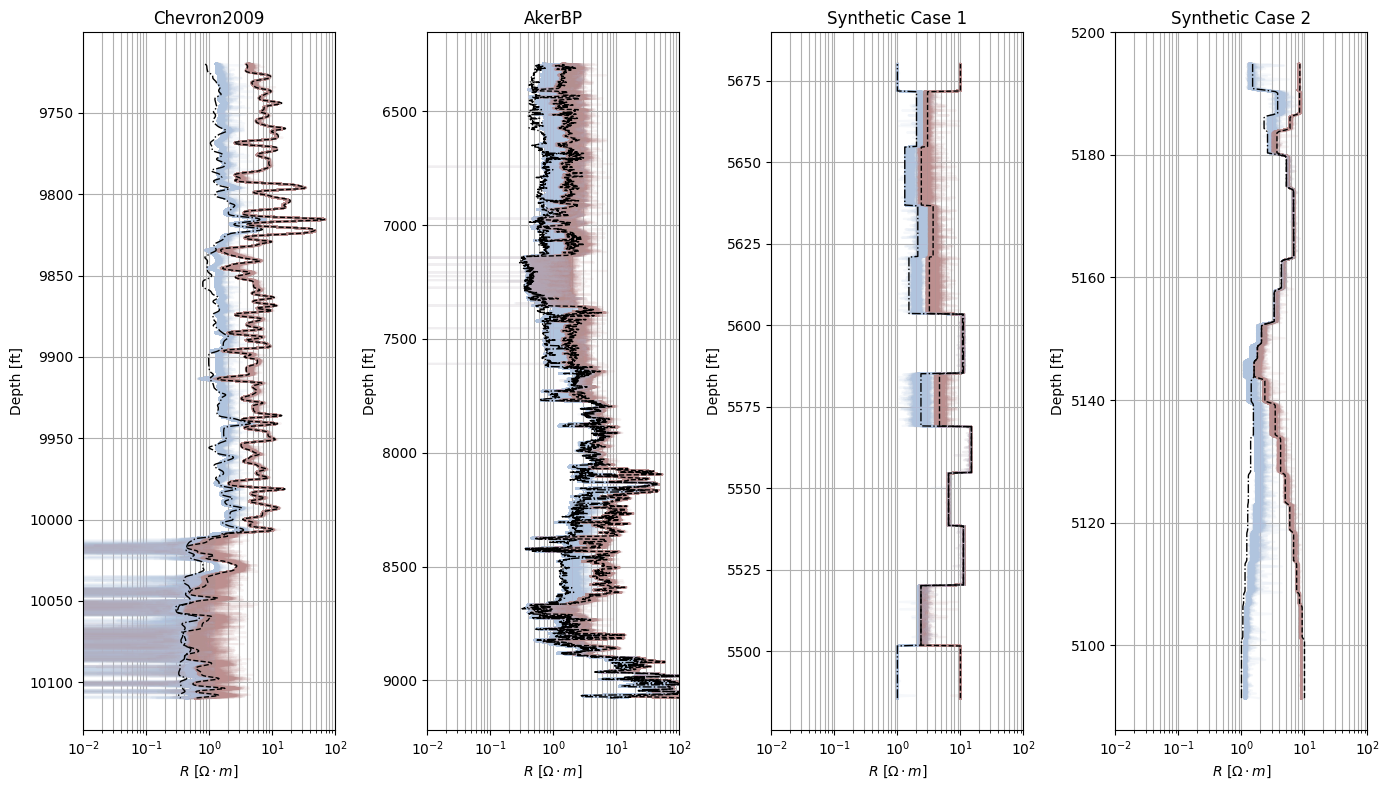

In [16]:
fig, axs = plt.subplots(1, 4, figsize=(14,8))
ax1, ax2, ax3, ax4 = axs
titles = ['Chevron2009', 'AkerBP', 'Synthetic Case 1', 'Synthetic Case 2']

for i in range(n_realizations):
    csh_chevron, rss_chevron = chevron_uq[i, :, 0], chevron_uq[i, :, 1]
    rvsh_chevron, rhsh_chevron = chevron_results['Rvsh'].values, chevron_results['Rhsh'].values
    rv_chevron = csh_chevron*rvsh_chevron + (1-csh_chevron)*rss_chevron
    rh_chevron = 1/(csh_chevron/rhsh_chevron + (1-csh_chevron)/rss_chevron)

    csh_akerbp, rss_akerbp = akerbp_uq[i, :, 0], akerbp_uq[i, :, 1]
    rvsh_akerbp, rhsh_akerbp = akerbp_results['Rvsh'].values, akerbp_results['Rhsh'].values
    rv_akerbp = csh_akerbp*rvsh_akerbp + (1-csh_akerbp)*rss_akerbp
    rh_akerbp = 1/(csh_akerbp/rhsh_akerbp + (1-csh_akerbp)/rss_akerbp)

    csh_synth1, rss_synth1 = synthetic1_uq[i, :, 0], synthetic1_uq[i, :, 1]
    rvsh_synth1, rhsh_synth1 = synth1_results['Rvsh'].values, synth1_results['Rhsh'].values
    rv_synth1 = csh_synth1*rvsh_synth1 + (1-csh_synth1)*rss_synth1
    rh_synth1 = 1/(csh_synth1/rhsh_synth1 + (1-csh_synth1)/rss_synth1)

    csh_synth2, rss_synth2 = synthetic2_uq[i, :, 0], synthetic2_uq[i, :, 1]
    rvsh_synth2, rhsh_synth2 = synth2_results['Rvsh'].values, synth2_results['Rhsh'].values
    rv_synth2 = csh_synth2*rvsh_synth2 + (1-csh_synth2)*rss_synth2
    rh_synth2 = 1/(csh_synth2/rhsh_synth2 + (1-csh_synth2)/rss_synth2)
    
    ax1.plot(rv_chevron, chevron_results.index, c='rosybrown', alpha=0.1)
    ax1.plot(rh_chevron, chevron_results.index, c='lightsteelblue', alpha=0.1)

    ax2.plot(rv_akerbp, akerbp_results.index, c='rosybrown', alpha=0.1)
    ax2.plot(rh_akerbp, akerbp_results.index, c='lightsteelblue', alpha=0.1)

    ax3.plot(rv_synth1, synth1_results.index, c='rosybrown', alpha=0.1)
    ax3.plot(rh_synth1, synth1_results.index, c='lightsteelblue', alpha=0.1)

    ax4.plot(rv_synth2, synth2_results.index, c='rosybrown', alpha=0.1)
    ax4.plot(rh_synth2, synth2_results.index, c='lightsteelblue', alpha=0.1)

ax1.plot(chevron_results['Rv'], chevron_results.index, c='k', lw=1, ls='--')
ax1.plot(chevron_results['Rh'], chevron_results.index, c='k', lw=1, ls='-.')

ax2.plot(akerbp_results['Rv'], akerbp_results.index, c='k', lw=1, ls='--')
ax2.plot(akerbp_results['Rh'], akerbp_results.index, c='k', lw=1, ls='-.')

ax3.plot(synth1_results['Rv'], synth1_results.index, c='k', lw=1, ls='--')
ax3.plot(synth1_results['Rh'], synth1_results.index, c='k', lw=1, ls='-.')

ax4.plot(synth2_results['Rv'], synth2_results.index, c='k', lw=1, ls='--')
ax4.plot(synth2_results['Rh'], synth2_results.index, c='k', lw=1, ls='-.')

[ax.set_title(titles[i]) for i, ax in enumerate(axs)]
[ax.set(xscale='log', ylabel='Depth [ft]', xlabel='$R$ $[\Omega\cdot m]$', xlim=(1e-2, 1e2)) for ax in axs]
[ax.grid(True, which='both') for ax in axs]
ax1.invert_yaxis(); ax2.invert_yaxis()
plt.tight_layout()
plt.show()

Quadratic inverison, uncertainty quantification

In [19]:
n_realizations = 100

chevron_q_uq = np.zeros((n_realizations, data1.shape[0], 2))
for i in tqdm(range(n_realizations)):
    rv, rh, rvsh, rhsh = data1['Rv'], data1['Rh'], data1['Rvsh'], data1['Rhsh']
    inputs = np.array([rv, rh]).T
    noisy_inputs = inputs + noise_level*np.random.lognormal(0, 1, size=(inputs.shape[0], 2))
    noisy_data   = np.concatenate([noisy_inputs, np.array([rvsh, rhsh]).T], axis=1)
    chevron_q_uq[i] = newton_inversion(pd.DataFrame(noisy_data, columns=[['Rv','Rh','Rvsh','Rhsh']]))

akerbp_q_uq = np.zeros((n_realizations, data2.shape[0], 2))
for i in tqdm(range(n_realizations)):
    rv, rh, rvsh, rhsh = data2['Rv'], data2['Rh'], data2['Rvsh'], data2['Rhsh']
    inputs = np.array([rv, rh]).T
    noisy_inputs = inputs + noise_level*np.random.lognormal(0, 1, size=(inputs.shape[0], 2))
    noisy_data   = np.concatenate([noisy_inputs, np.array([rvsh, rhsh]).T], axis=1)
    akerbp_q_uq[i] = newton_inversion(pd.DataFrame(noisy_data, columns=[['Rv','Rh','Rvsh','Rhsh']]))

synth1_q_uq = np.zeros((n_realizations, data3.shape[0], 2))
for i in tqdm(range(n_realizations)):
    rv, rh, rvsh, rhsh = data3['Rv'], data3['Rh'], data3['Rvsh'], data3['Rhsh']
    inputs = np.array([rv, rh]).T
    noisy_inputs = inputs + noise_level*np.random.lognormal(0, 1, size=(inputs.shape[0], 2))
    noisy_data   = np.concatenate([noisy_inputs, np.array([rvsh, rhsh]).T], axis=1)
    synth1_q_uq[i] = newton_inversion(pd.DataFrame(noisy_data, columns=[['Rv','Rh','Rvsh','Rhsh']]))

synth2_q_uq = np.zeros((n_realizations, data4.shape[0], 2))
for i in tqdm(range(n_realizations)):
    rv, rh, rvsh, rhsh = data4['Rv'], data4['Rh'], data4['Rvsh'], data4['Rhsh']
    inputs = np.array([rv, rh]).T
    noisy_inputs = inputs + noise_level*np.random.lognormal(0, 1, size=(inputs.shape[0], 2))
    noisy_data   = np.concatenate([noisy_inputs, np.array([rvsh, rhsh]).T], axis=1)
    synth2_q_uq[i] = newton_inversion(pd.DataFrame(noisy_data, columns=[['Rv','Rh','Rvsh','Rhsh']]))

100%|██████████| 100/100 [00:18<00:00,  5.39it/s]


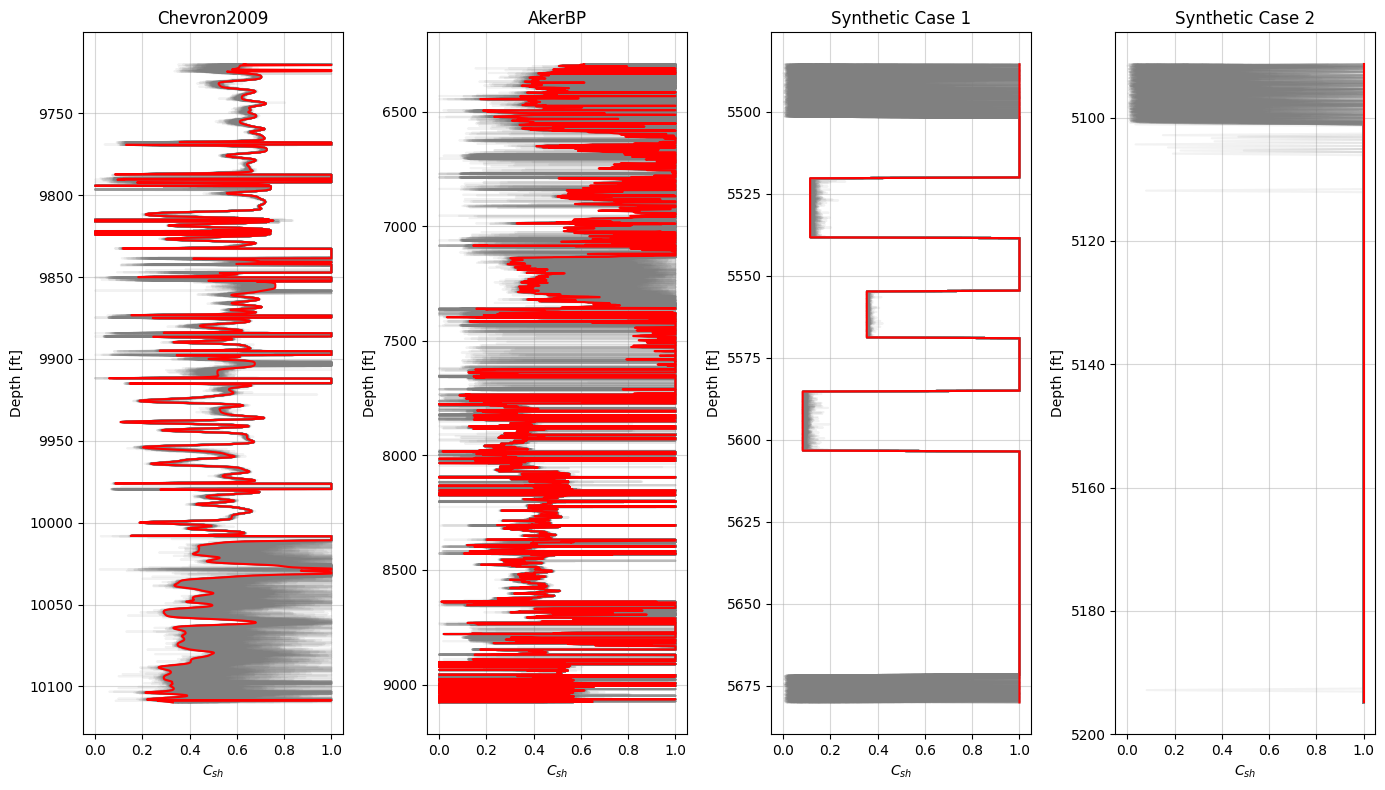

In [20]:
fig, axs = plt.subplots(1, 4, figsize=(14,8))
ax1, ax2, ax3, ax4 = axs
titles = ['Chevron2009', 'AkerBP', 'Synthetic Case 1', 'Synthetic Case 2']

for i in range(n_realizations):
    ax1.plot(chevron_q_uq[i,:,0], data1.index, color='gray', alpha=0.1)
    ax2.plot(akerbp_q_uq[i,:,0], data2.index, color='gray', alpha=0.1)
    ax3.plot(synth1_q_uq[i,:,0], data3.index, color='gray', alpha=0.1)
    ax4.plot(synth2_q_uq[i,:,0], data4.index, color='gray', alpha=0.1)

ax1.plot(chevron_results['Csh_q'], chevron_results.index, color='red')
ax2.plot(akerbp_results['Csh_q'], akerbp_results.index, color='red')
ax3.plot(synth1_results['Csh_q'], synth1_results.index, color='red')
ax4.plot(synth2_results['Csh_q'], synth2_results.index, color='red')

[ax.set(title=titles[i], xlabel='$C_{sh}$', ylabel='Depth [ft]') for i, ax in enumerate(axs)]
[ax.invert_yaxis() for ax in axs]
[ax.grid(True, which='both', alpha=0.5) for ax in axs]
plt.tight_layout()
plt.show()

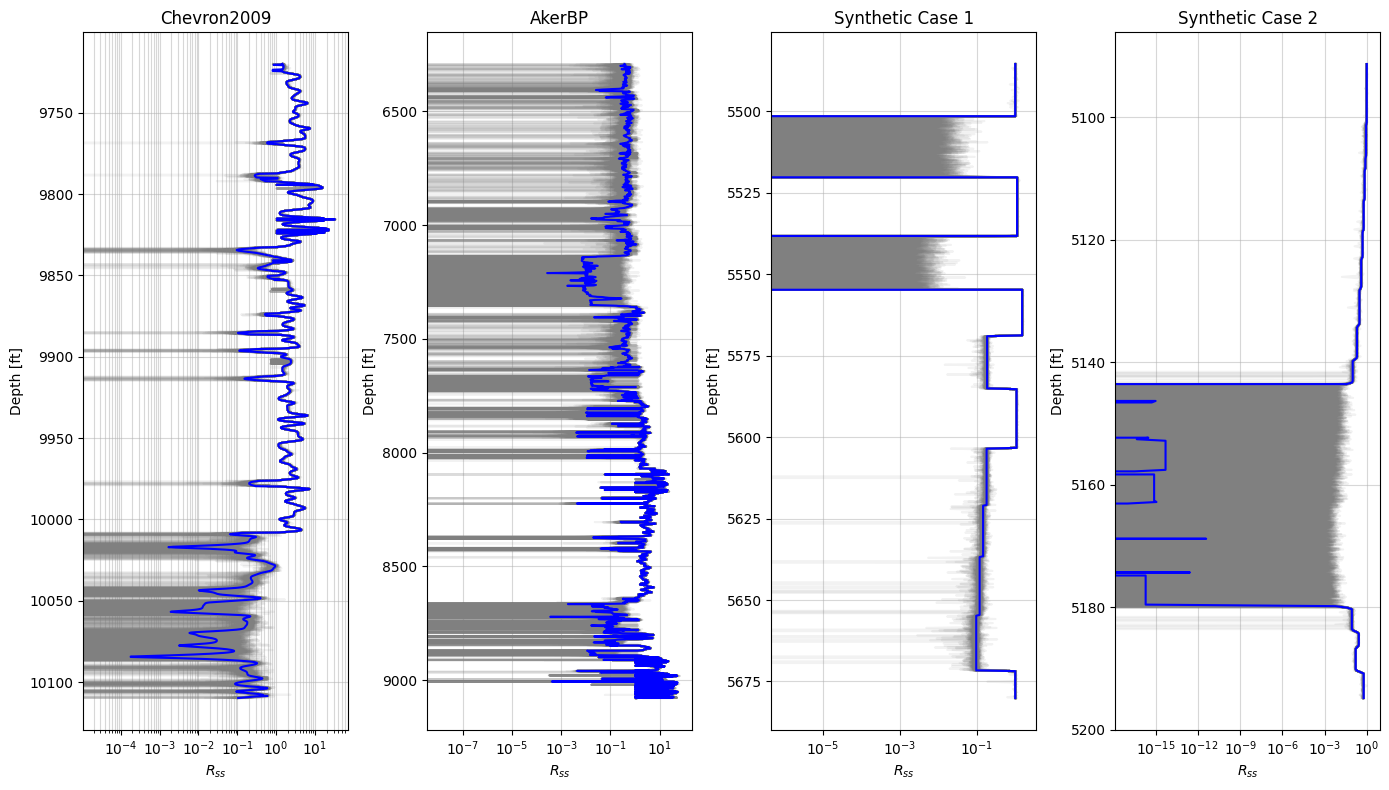

In [21]:
fig, axs = plt.subplots(1, 4, figsize=(14,8))
ax1, ax2, ax3, ax4 = axs

for i in range(n_realizations):
    ax1.plot(chevron_q_uq[i,:,1], data1.index, color='gray', alpha=0.1)
    ax2.plot(akerbp_q_uq[i,:,1], data2.index, color='gray', alpha=0.1)
    ax3.plot(synth1_q_uq[i,:,1], data3.index, color='gray', alpha=0.1)
    ax4.plot(synth2_q_uq[i,:,1], data4.index, color='gray', alpha=0.1)

ax1.plot(chevron_results['Rss_q'], chevron_results.index, color='blue')
ax2.plot(akerbp_results['Rss_q'], akerbp_results.index, color='blue')
ax3.plot(synth1_results['Rss_q'], synth1_results.index, color='blue')
ax4.plot(synth2_results['Rss_q'], synth2_results.index, color='blue')

[ax.set(title=titles[i], xlabel='$R_{ss}$', ylabel='Depth [ft]', xscale='log') for i, ax in enumerate(axs)]
[ax.invert_yaxis() for ax in axs]
[ax.grid(True, which='both', alpha=0.5) for ax in axs]
plt.tight_layout()
plt.show()

In [22]:
chevron_q_csh_range, chevron_q_rss_range = [], []
for i in range(n_realizations):
    p10_csh, p90_csh = np.percentile(chevron_q_uq[i,:,0], 10), np.percentile(chevron_q_uq[i,:,0], 90)
    p10_rss, p90_rss = np.percentile(chevron_q_uq[i,:,1], 10), np.percentile(chevron_q_uq[i,:,1], 90)
    chevron_q_csh_range.append(p90_csh - p10_csh)
    chevron_q_rss_range.append(p90_rss - p10_rss)
chevron_q_csh_range, chevron_q_rss_range = np.array(chevron_q_csh_range), np.array(chevron_q_rss_range)

akerbp_q_csh_range, akerbp_q_rss_range = [], []
for i in range(n_realizations):
    p10_csh, p90_csh = np.percentile(akerbp_q_uq[i,:,0], 10), np.percentile(akerbp_q_uq[i,:,0], 90)
    p10_rss, p90_rss = np.percentile(akerbp_q_uq[i,:,1], 10), np.percentile(akerbp_q_uq[i,:,1], 90)
    akerbp_q_csh_range.append(p90_csh - p10_csh)
    akerbp_q_rss_range.append(p90_rss - p10_rss)
akerbp_q_csh_range, akerbp_q_rss_range = np.array(akerbp_q_csh_range), np.array(akerbp_q_rss_range)

synth1_q_csh_range, synth1_q_rss_range = [], []
for i in range(n_realizations):
    p10_csh, p90_csh = np.percentile(synth1_q_uq[i,:,0], 10), np.percentile(synth1_q_uq[i,:,0], 90)
    p10_rss, p90_rss = np.percentile(synth1_q_uq[i,:,1], 10), np.percentile(synth1_q_uq[i,:,1], 90)
    synth1_q_csh_range.append(p90_csh - p10_csh)
    synth1_q_rss_range.append(p90_rss - p10_rss)
synth1_q_csh_range, synth1_q_rss_range = np.array(synth1_q_csh_range), np.array(synth1_q_rss_range)

synth2_q_csh_range, synth2_q_rss_range = [], []
for i in range(n_realizations):
    p10_csh, p90_csh = np.percentile(synth2_q_uq[i,:,0], 10), np.percentile(synth2_q_uq[i,:,0], 90)
    p10_rss, p90_rss = np.percentile(synth2_q_uq[i,:,1], 10), np.percentile(synth2_q_uq[i,:,1], 90)
    synth2_q_csh_range.append(p90_csh - p10_csh)
    synth2_q_rss_range.append(p90_rss - p10_rss)
synth2_q_csh_range, synth2_q_rss_range = np.array(synth2_q_csh_range), np.array(synth2_q_rss_range)

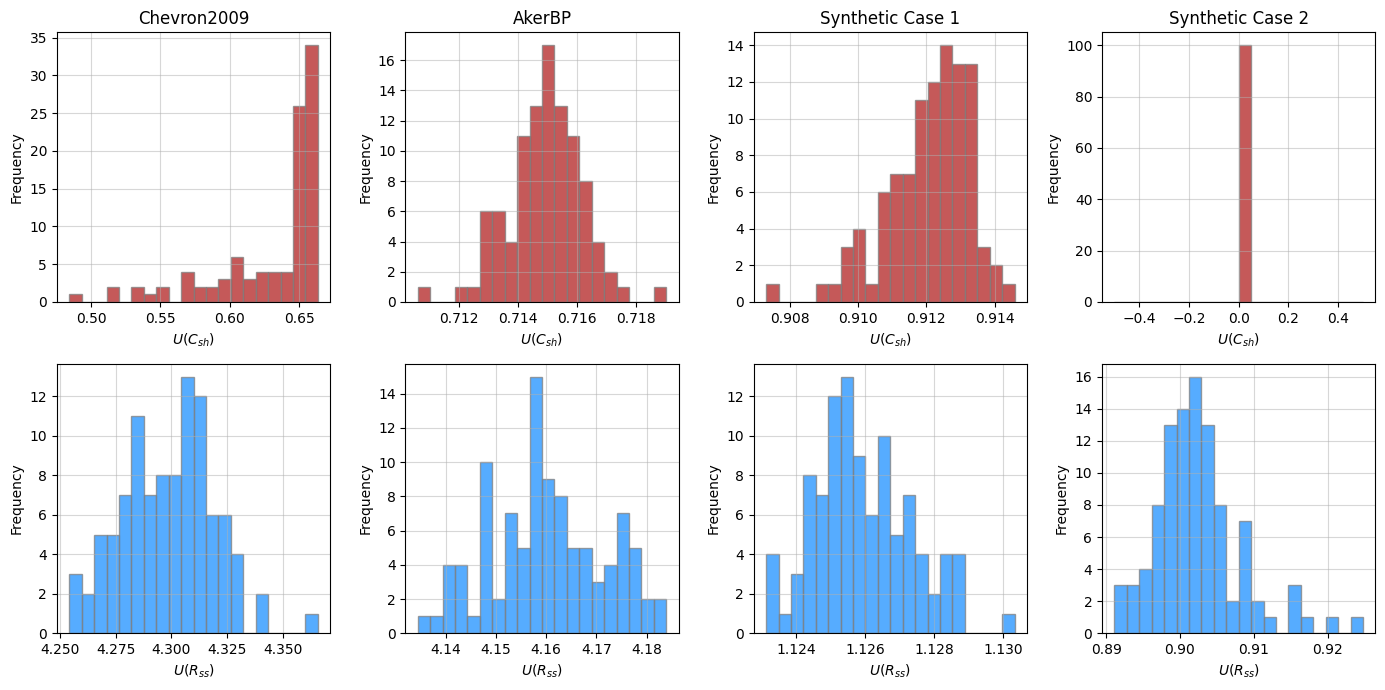

In [23]:
fig, axs = plt.subplots(2, 4, figsize=(14,7))
ax1, ax2, ax3, ax4 = axs[0]
ax5, ax6, ax7, ax8 = axs[1]

ax1.hist(chevron_q_csh_range, bins=20, color='firebrick', alpha=0.75, edgecolor='gray')
ax2.hist(akerbp_q_csh_range, bins=20, color='firebrick', alpha=0.75, edgecolor='gray')
ax3.hist(synth1_q_csh_range, bins=20, color='firebrick', alpha=0.75, edgecolor='gray')
ax4.hist(synth2_q_csh_range, bins=20, color='firebrick', alpha=0.75, edgecolor='gray')
[ax.grid(True, which='both', alpha=0.5) for ax in axs[0]]
[ax.set(xlabel='$U(C_{sh})$', ylabel='Frequency', title=titles[i]) for i, ax in enumerate(axs[0])]

ax5.hist(chevron_q_rss_range, bins=20, color='dodgerblue', alpha=0.75, edgecolor='gray')
ax6.hist(akerbp_q_rss_range, bins=20, color='dodgerblue', alpha=0.75, edgecolor='gray')
ax7.hist(synth1_q_rss_range, bins=20, color='dodgerblue', alpha=0.75, edgecolor='gray')
ax8.hist(synth2_q_rss_range, bins=20, color='dodgerblue', alpha=0.75, edgecolor='gray')
[ax.grid(True, which='both', alpha=0.5) for ax in axs[1]]
[ax.set(xlabel='$U(R_{ss})$', ylabel='Frequency') for ax in axs[1]]

plt.tight_layout()
plt.show()

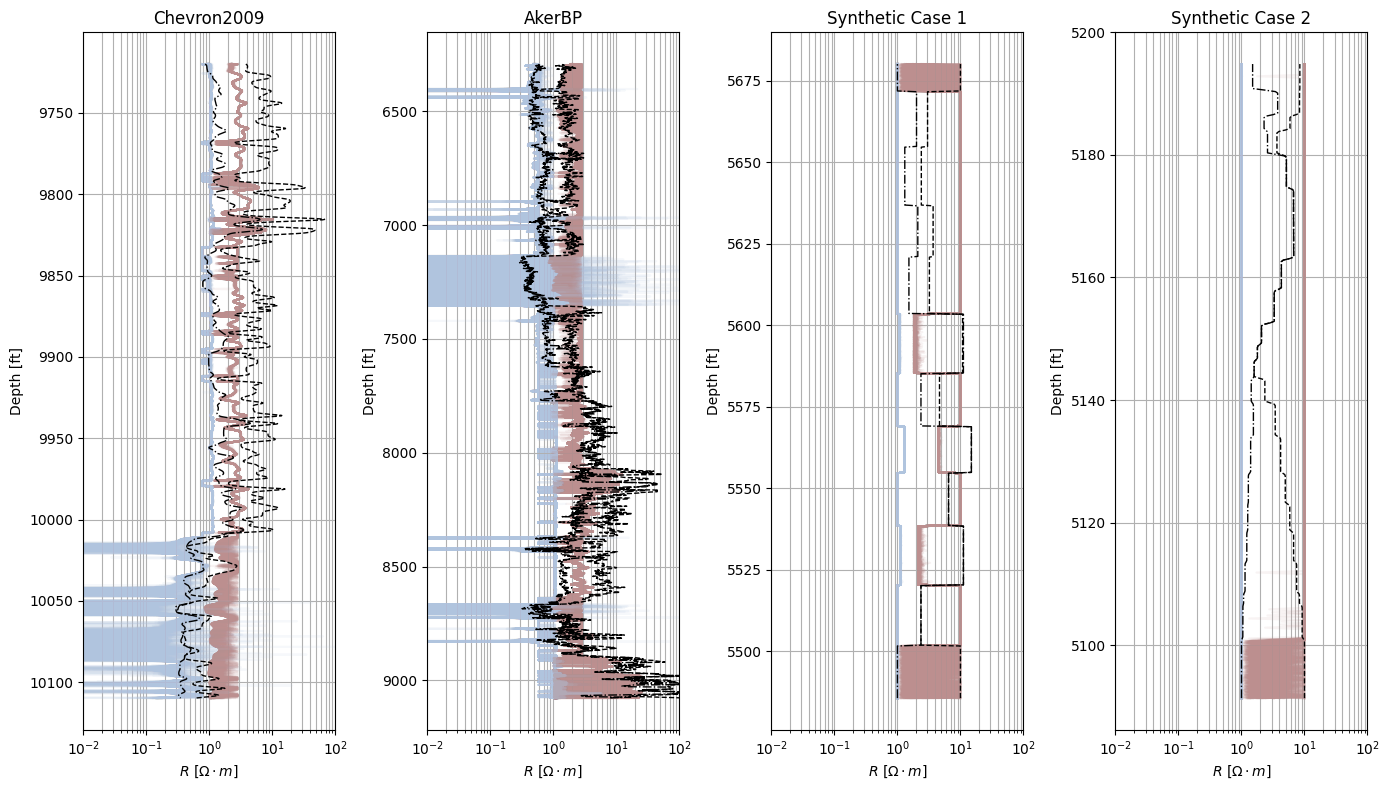

In [24]:
fig, axs = plt.subplots(1, 4, figsize=(14,8))
ax1, ax2, ax3, ax4 = axs
titles = ['Chevron2009', 'AkerBP', 'Synthetic Case 1', 'Synthetic Case 2']

for i in range(n_realizations):
    csh_chevron, rss_chevron = chevron_q_uq[i, :, 0], chevron_q_uq[i, :, 1]
    rvsh_chevron, rhsh_chevron = chevron_results['Rvsh'].values, chevron_results['Rhsh'].values
    rv_chevron = csh_chevron*rvsh_chevron + (1-csh_chevron)*rss_chevron
    rh_chevron = 1/(csh_chevron/rhsh_chevron + (1-csh_chevron)/rss_chevron)

    csh_akerbp, rss_akerbp = akerbp_q_uq[i, :, 0], akerbp_q_uq[i, :, 1]
    rvsh_akerbp, rhsh_akerbp = akerbp_results['Rvsh'].values, akerbp_results['Rhsh'].values
    rv_akerbp = csh_akerbp*rvsh_akerbp + (1-csh_akerbp)*rss_akerbp
    rh_akerbp = 1/(csh_akerbp/rhsh_akerbp + (1-csh_akerbp)/rss_akerbp)

    csh_synth1, rss_synth1 = synth1_q_uq[i, :, 0], synth1_q_uq[i, :, 1]
    rvsh_synth1, rhsh_synth1 = synth1_results['Rvsh'].values, synth1_results['Rhsh'].values
    rv_synth1 = csh_synth1*rvsh_synth1 + (1-csh_synth1)*rss_synth1
    rh_synth1 = 1/(csh_synth1/rhsh_synth1 + (1-csh_synth1)/rss_synth1)

    csh_synth2, rss_synth2 = synth2_q_uq[i, :, 0], synth2_q_uq[i, :, 1]
    rvsh_synth2, rhsh_synth2 = synth2_results['Rvsh'].values, synth2_results['Rhsh'].values
    rv_synth2 = csh_synth2*rvsh_synth2 + (1-csh_synth2)*rss_synth2
    rh_synth2 = 1/(csh_synth2/rhsh_synth2 + (1-csh_synth2)/rss_synth2)
    
    ax1.plot(rv_chevron, chevron_results.index, c='rosybrown', alpha=0.1)
    ax1.plot(rh_chevron, chevron_results.index, c='lightsteelblue', alpha=0.1)

    ax2.plot(rv_akerbp, akerbp_results.index, c='rosybrown', alpha=0.1)
    ax2.plot(rh_akerbp, akerbp_results.index, c='lightsteelblue', alpha=0.1)

    ax3.plot(rv_synth1, synth1_results.index, c='rosybrown', alpha=0.1)
    ax3.plot(rh_synth1, synth1_results.index, c='lightsteelblue', alpha=0.1)

    ax4.plot(rv_synth2, synth2_results.index, c='rosybrown', alpha=0.1)
    ax4.plot(rh_synth2, synth2_results.index, c='lightsteelblue', alpha=0.1)

ax1.plot(chevron_results['Rv'], chevron_results.index, c='k', lw=1, ls='--')
ax1.plot(chevron_results['Rh'], chevron_results.index, c='k', lw=1, ls='-.')

ax2.plot(akerbp_results['Rv'], akerbp_results.index, c='k', lw=1, ls='--')
ax2.plot(akerbp_results['Rh'], akerbp_results.index, c='k', lw=1, ls='-.')

ax3.plot(synth1_results['Rv'], synth1_results.index, c='k', lw=1, ls='--')
ax3.plot(synth1_results['Rh'], synth1_results.index, c='k', lw=1, ls='-.')

ax4.plot(synth2_results['Rv'], synth2_results.index, c='k', lw=1, ls='--')
ax4.plot(synth2_results['Rh'], synth2_results.index, c='k', lw=1, ls='-.')

[ax.set_title(titles[i]) for i, ax in enumerate(axs)]
[ax.set(xscale='log', ylabel='Depth [ft]', xlabel='$R$ $[\Omega\cdot m]$', xlim=(1e-2, 1e2)) for ax in axs]
[ax.grid(True, which='both') for ax in axs]
ax1.invert_yaxis(); ax2.invert_yaxis()
plt.tight_layout()
plt.show()

***
# END